In [8]:
import os
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from influencemaximization import InfluenceMaximization 
from graphprocessor import GraphProcessor
import random

In [12]:
graph_dir = "data\\barabasi_albert_snapshots-lables"
# Load the sample graph (Graph 1)
graph_path = graph_dir + '\\snapshot_14.gpickle'  # Replace with the correct graph path
G = nx.read_gpickle(graph_path)

In [13]:
# Initialize the Influence Maximization class
inf_max = InfluenceMaximization(graph=G, propagation_probability=0.01, monte_carlo=100)

# Run the greedy algorithm for different k values
for k in [5, 10, 20]:
    seed_set, spread, timelapse = inf_max.greedy(k=k)
    print(f"Greedy Algorithm for k={k}:")
    print(f"Seed Set: {seed_set}")
    print(f"Spread: {spread[-1]}")
    print(f"Time: {timelapse[-1]:.2f} seconds")

Greedy Algorithm for k=5:
Seed Set: [0, 29, 62, 36, 22]
Spread: 13.51
Time: 5.06 seconds
Greedy Algorithm for k=10:
Seed Set: [0, 29, 62, 36, 22, 6, 10, 1, 60, 17]
Spread: 19.75
Time: 13.45 seconds
Greedy Algorithm for k=20:
Seed Set: [0, 29, 62, 36, 22, 6, 10, 1, 60, 17, 14, 24, 86, 91, 63, 59, 88, 97, 11, 77]
Spread: 30.48
Time: 35.78 seconds


In [ ]:
G = nx.erdos_renyi_graph(1000, 0.01, seed=None, directed=True)
print(f"Number of Nodes: {G.number_of_nodes()}")
print(f"Number of Edges: {G.number_of_edges()}")


Number of Nodes: 1000
Number of Edges: 10052


In [20]:
# Initialize GraphProcessor
graph_processor = GraphProcessor()
G = graph_processor.add_features_to_graph(G)
# Add labels based on IFC score (top 30% of nodes)
G = graph_processor.add_labels_to_graph(G, top_percentage=30)

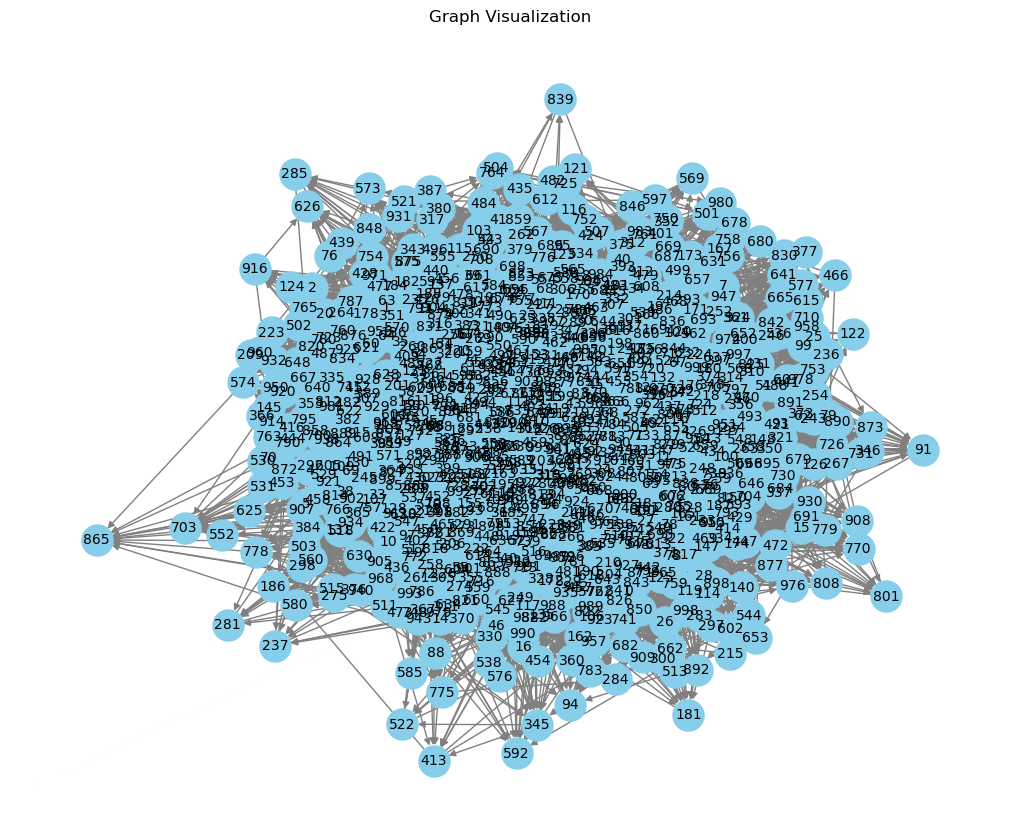

<bound method Graph.number_of_nodes of <networkx.classes.digraph.DiGraph object at 0x0000025CEA564C10>> <bound method Graph.number_of_edges of <networkx.classes.digraph.DiGraph object at 0x0000025CEA564C10>>

Details of Node 335:
  Features: [19, 0.002252196203671957, 14, 11.0, 0.3353832442067736]
  Label: 0


In [21]:
# Visualize the graph
plt.figure(figsize=(10, 8))
pos = nx.spring_layout(G)  # Compute layout for visualization
nx.draw(G, pos, with_labels=True, node_color="skyblue", edge_color="gray", node_size=500, font_size=10)
plt.title("Graph Visualization")
plt.show()

print(G.number_of_nodes, G.number_of_edges)

# Select a random node and print its details
random_node = random.choice(list(G.nodes))
node_data = G.nodes[random_node]
# Find and print nodes with label 1
nodes_with_label_1 = [node for node, data in G.nodes(data=True) if data.get("label") == 1]

print(f"\nDetails of Node {random_node}:")
print(f"  Features: {node_data.get('features', 'No features found')}")
print(f"  Label: {node_data.get('label', 'No label found')}")

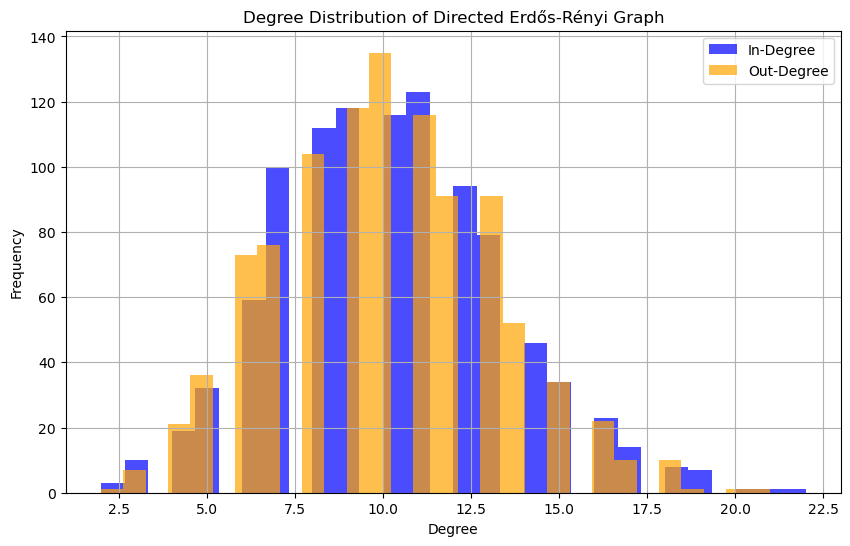

In [22]:
import matplotlib.pyplot as plt

# Calculate in-degree and out-degree
in_degrees = [d for _, d in G.in_degree()]
out_degrees = [d for _, d in G.out_degree()]

# Plot in-degree distribution
plt.figure(figsize=(10, 6))
plt.hist(in_degrees, bins=30, alpha=0.7, label="In-Degree", color="blue")
plt.hist(out_degrees, bins=30, alpha=0.7, label="Out-Degree", color="orange")
plt.title("Degree Distribution of Directed Erdős-Rényi Graph")
plt.xlabel("Degree")
plt.ylabel("Frequency")
plt.legend()
plt.grid()
plt.show()

In [23]:
# Find and print nodes with label 1
nodes_with_label_1 = [node for node, data in G.nodes(data=True) if data.get("label") == 1]
# Print the count of nodes with label 1
count_label_1 = len(nodes_with_label_1)
print(f"\nNumber of nodes with label 1: {count_label_1}")


Number of nodes with label 1: 300


# Approach
Key Definitions:
k: Number of seed nodes used to compute influence spread for all heuristics and greedy algorithms. \\
m: Number of candidate nodes used to filter/select top nodes for heuristic-based methods (e.g., Degree, Betweenness).\\

## Steps:

Use greedy directly with k to compute the spread for the greedy algorithm.
For each heuristic:
Select the top m nodes (candidate nodes).
Use these m nodes to compute the spread with k seed nodes selected from the top of the candidate set.
Plot:
Influence spread for greedy and all heuristic approaches.
Computation time for each approach.

In [27]:
# Initialize Influence Maximization Class
inf_max = InfluenceMaximization(graph=G, propagation_probability=0.05, monte_carlo=50)

# Step 1: Extract Candidate Nodes Based on IFC Score
nodes_with_ifc_label_1 = [node for node, data in G.nodes(data=True) if data.get("label") == 1]
m = len(nodes_with_ifc_label_1)  # Number of candidate nodes

# Step 2: Select Top-m Nodes for Each Heuristic
def select_top_m_nodes(G, m, heuristic_index):
    """
    Select the top-m nodes based on the given heuristic index.
    """
    nodes_with_features = [(node, G.nodes[node]["features"][heuristic_index]) for node in G.nodes]
    sorted_nodes = sorted(nodes_with_features, key=lambda x: x[1], reverse=True)
    return [node for node, _ in sorted_nodes[:m]]

heuristics = {
    "Degree": 0,
    "Betweenness": 1,
    "K-Core": 2,
    "Average Neighbor Degree": 3,
    "IFC Score": 4
}

candidate_sets = {heuristic: select_top_m_nodes(G, m, index) for heuristic, index in heuristics.items()}

# Initialize Results Dictionary
results = {
    "Number of Nodes": G.number_of_nodes(),
    "Number of Edges": G.number_of_edges(),
    "Greedy Spread": {},
    "Greedy Time": {},
}

for heuristic in heuristics:
    results[f"{heuristic} Spread"] = {}
    results[f"{heuristic} Time"] = {}

# Step 3: Compute Influence Spread and Time for Each Heuristic
k_values = [5, 10]  # Seed sizes
for k in k_values:
    print(f"\nRunning computations for k={k}...\n")

    # Greedy Algorithm
    print(f"Running Greedy for k={k}...")
    seed_set, spread, timelapse = inf_max.greedy(k=k)
    results["Greedy Spread"][k] = spread[-1]  # Final spread
    results["Greedy Time"][k] = timelapse[-1]  # Final time

    # Heuristic-Based Approaches
    for heuristic, candidate_set in candidate_sets.items():
        print(f"Running {heuristic}-based for k={k}...")
        seed_set = candidate_set[:k]  # Select top-k nodes from the candidate set
        heuristic_seed_set, heuristic_spread, heuristic_timelapse = inf_max.greedy_mod(k=k, candidatenodelist= candidate_set)
  
        results[f"{heuristic} Spread"][k] =heuristic_spread[-1]
        results[f"{heuristic} Time"][k] =  heuristic_timelapse [-1] # Negligible time for heuristic selection






Running computations for k=5...

Running Greedy for k=5...
Running Degree-based for k=5...
Running Betweenness-based for k=5...
Running K-Core-based for k=5...
Running Average Neighbor Degree-based for k=5...
Running IFC Score-based for k=5...

Running computations for k=10...

Running Greedy for k=10...
Running Degree-based for k=10...
Running Betweenness-based for k=10...
Running K-Core-based for k=10...
Running Average Neighbor Degree-based for k=10...
Running IFC Score-based for k=10...


In [25]:
results

{'Number of Nodes': 1000,
 'Number of Edges': 10052,
 'Greedy Spread': {5: 24.8, 10: 36.9},
 'Greedy Time': {5: 7.639112234115601, 10: 56.67237710952759},
 'Degree Spread': {5: 23.9, 10: 35.0},
 'Degree Time': {5: 2.072164297103882, 10: 16.59725260734558},
 'Betweenness Spread': {5: 23.6, 10: 34.4},
 'Betweenness Time': {5: 2.051529884338379, 10: 15.881485939025879},
 'K-Core Spread': {5: 24.4, 10: 36.3},
 'K-Core Time': {5: 2.28433895111084, 10: 16.63640832901001},
 'Average Neighbor Degree Spread': {5: 24.9, 10: 36.6},
 'Average Neighbor Degree Time': {5: 3.6329476833343506,
  10: 16.34007215499878},
 'IFC Score Spread': {5: 24.1, 10: 35.6},
 'IFC Score Time': {5: 5.518291711807251, 10: 16.20614504814148}}

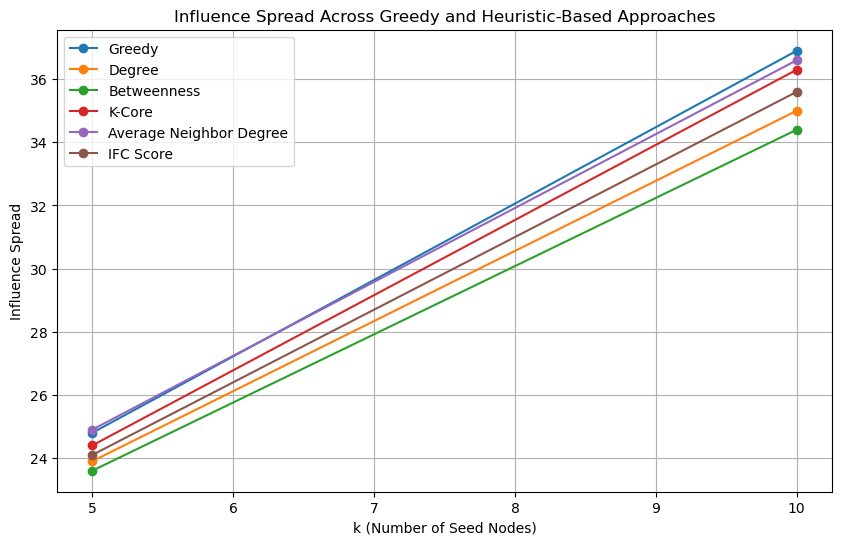

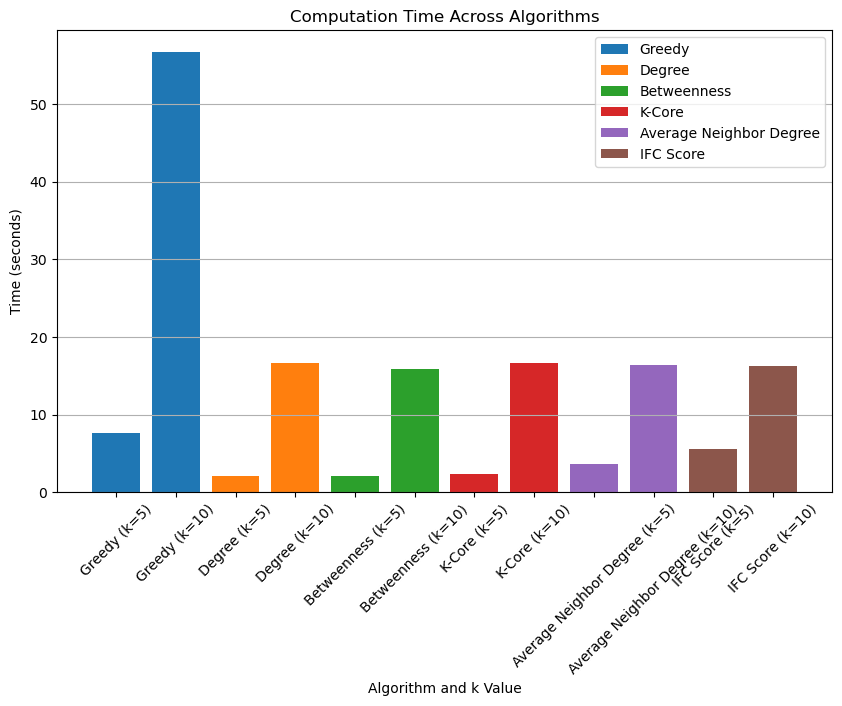

In [26]:
# Plot 1: Influence Spread
plt.figure(figsize=(10, 6))
for method in ["Greedy"] + list(heuristics.keys()):
    plt.plot(
        k_values,
        [results[f"{method} Spread"][k] for k in k_values],
        label=method,
        marker="o"
    )
plt.title("Influence Spread Across Greedy and Heuristic-Based Approaches")
plt.xlabel("k (Number of Seed Nodes)")
plt.ylabel("Influence Spread")
plt.legend()
plt.grid()
plt.show()

# Plot 2: Computation Time
plt.figure(figsize=(10, 6))
for method in ["Greedy"] + list(heuristics.keys()):
    plt.bar(
        [f"{method} (k={k})" for k in k_values],
        [results[f"{method} Time"][k] for k in k_values],
        label=method,
    )
plt.title("Computation Time Across Algorithms")
plt.ylabel("Time (seconds)")
plt.xlabel("Algorithm and k Value")
plt.xticks(rotation=45)
plt.grid(axis="y")
plt.legend()
plt.show()

In [58]:
# Parameters
num_nodes = 5000  # Adjust for graph size
edge_prob = 0.005  # Probability of edge creation (low for sparsity)
seed = 42  # For reproducibility
# Create a directed graph using Erdős–Rényi model with the specified edge probability
G = nx.gnp_random_graph(num_nodes, edge_prob, directed=True, seed=seed)
print(f"Number of Nodes: {G.number_of_nodes()}")
print(f"Number of Edges: {G.number_of_edges()}")

Number of Nodes: 5000
Number of Edges: 124455


In [59]:
# Initialize GraphProcessor
graph_processor = GraphProcessor()
G = graph_processor.add_features_to_graph(G)
# Add labels based on IFC score (top 30% of nodes)
G = graph_processor.add_labels_to_graph(G, top_percentage=40)

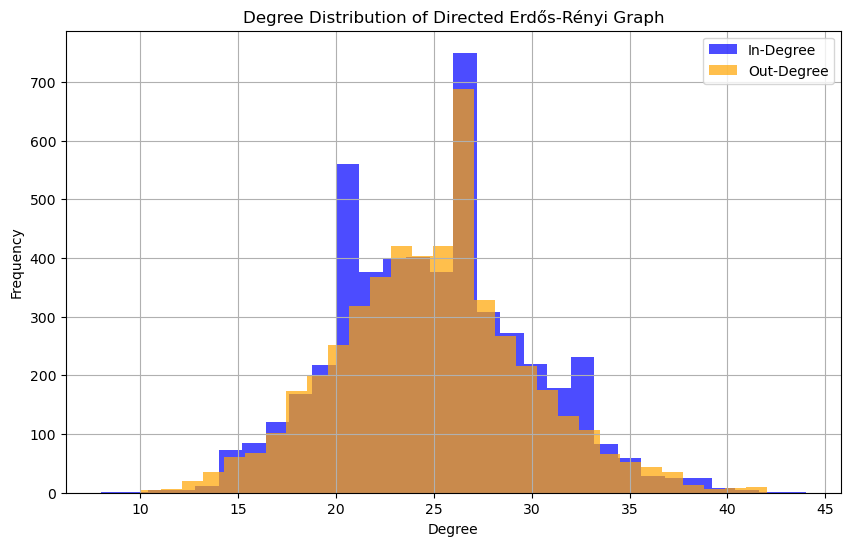

In [60]:
import matplotlib.pyplot as plt

# Calculate in-degree and out-degree
in_degrees = [d for _, d in G.in_degree()]
out_degrees = [d for _, d in G.out_degree()]

# Plot in-degree distribution
plt.figure(figsize=(10, 6))
plt.hist(in_degrees, bins=30, alpha=0.7, label="In-Degree", color="blue")
plt.hist(out_degrees, bins=30, alpha=0.7, label="Out-Degree", color="orange")
plt.title("Degree Distribution of Directed Erdős-Rényi Graph")
plt.xlabel("Degree")
plt.ylabel("Frequency")
plt.legend()
plt.grid()
plt.show()

In [61]:
# Initialize Influence Maximization Class
inf_max = InfluenceMaximization(graph=G, propagation_probability=0.1, monte_carlo=1)

# Step 1: Extract Candidate Nodes Based on IFC Score
nodes_with_ifc_label_1 = [node for node, data in G.nodes(data=True) if data.get("label") == 1]
m = len(nodes_with_ifc_label_1)  # Number of candidate nodes

# Step 2: Select Top-m Nodes for Each Heuristic
def select_top_m_nodes(G, m, heuristic_index):
    """
    Select the top-m nodes based on the given heuristic index.
    """
    nodes_with_features = [(node, G.nodes[node]["features"][heuristic_index]) for node in G.nodes]
    sorted_nodes = sorted(nodes_with_features, key=lambda x: x[1], reverse=True)
    return [node for node, _ in sorted_nodes[:m]]

heuristics = {
    "Degree": 0,
    "Betweenness": 1,
    "K-Core": 2,
    "Average Neighbor Degree": 3,
    "IFC Score": 4
}

candidate_sets = {heuristic: select_top_m_nodes(G, m, index) for heuristic, index in heuristics.items()}

# Initialize Results Dictionary
results = {
    "Number of Nodes": G.number_of_nodes(),
    "Number of Edges": G.number_of_edges(),
    "Greedy Spread": {},
    "Greedy Time": {},
}

for heuristic in heuristics:
    results[f"{heuristic} Spread"] = {}
    results[f"{heuristic} Time"] = {}

k_max = 20  # Maximum seed size
print(f"\nRunning computations for k={k_max}...\n")

# Initialize results storage
results = {"Greedy Spread": [], "Greedy Time": []}
for heuristic in candidate_sets:
    results[f"{heuristic} Spread"] = []
    results[f"{heuristic} Time"] = []

# Greedy Algorithm for k_max
print(f"Running Greedy for k={k_max}...")
greedy_seed_set, greedy_spread, greedy_timelapse = inf_max.greedy(k=k_max)

# Store results for all k values
results["Greedy Spread"] = greedy_spread[:k_max]  # Spread values for all k
results["Greedy Time"] = greedy_timelapse[:k_max]  # Time values for all k

# Heuristic-Based Approaches for k_max
for heuristic, candidate_set in candidate_sets.items():
    print(f"Running {heuristic}-based for k={k_max}...")
    heuristic_seed_set, heuristic_spread, heuristic_timelapse = inf_max.greedy_mod(
        k=k_max, candidatenodelist=candidate_set
    )
    # Store results for all k values
    results[f"{heuristic} Spread"] = heuristic_spread[:k_max]
    results[f"{heuristic} Time"] = heuristic_timelapse[:k_max]






Running computations for k=20...

Running Greedy for k=20...
Running Degree-based for k=20...
Running Betweenness-based for k=20...
Running K-Core-based for k=20...
Running Average Neighbor Degree-based for k=20...
Running IFC Score-based for k=20...


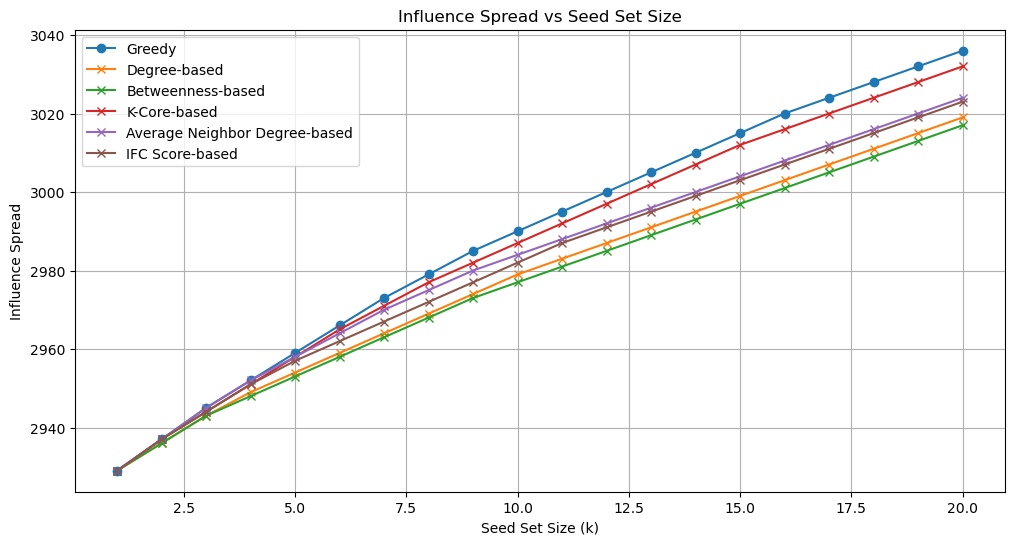

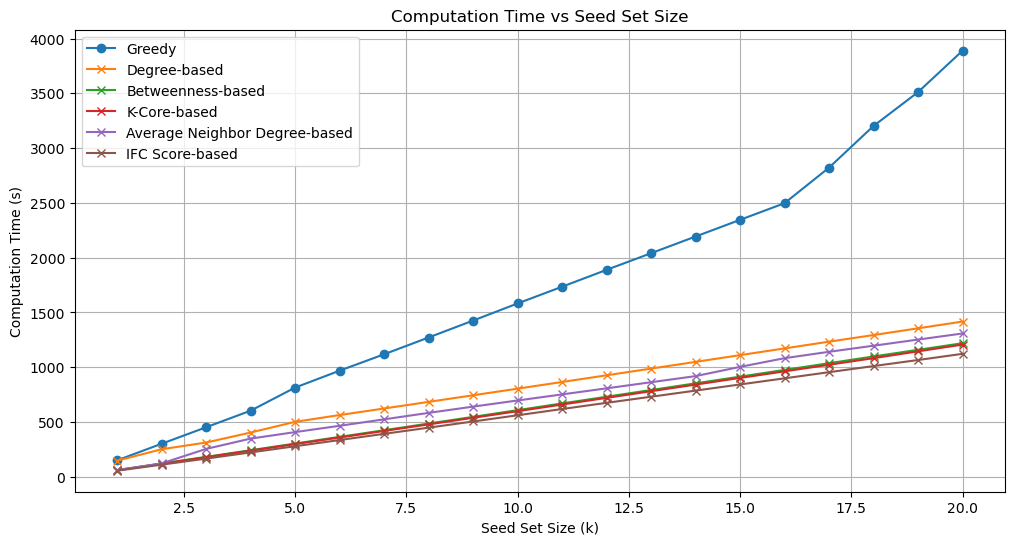

In [62]:
# Plot Results for All k
import matplotlib.pyplot as plt

ks = range(1, k_max + 1)

# Spread Plot
plt.figure(figsize=(12, 6))
plt.plot(ks, results["Greedy Spread"], label="Greedy", marker="o")
for heuristic in candidate_sets:
    plt.plot(ks, results[f"{heuristic} Spread"], label=f"{heuristic}-based", marker="x")
plt.xlabel("Seed Set Size (k)")
plt.ylabel("Influence Spread")
plt.title("Influence Spread vs Seed Set Size")
plt.legend()
plt.grid(True)
plt.show()

# Time Plot
plt.figure(figsize=(12, 6))
plt.plot(ks, results["Greedy Time"], label="Greedy", marker="o")
for heuristic in candidate_sets:
    plt.plot(ks, results[f"{heuristic} Time"], label=f"{heuristic}-based", marker="x")
plt.xlabel("Seed Set Size (k)")
plt.ylabel("Computation Time (s)")
plt.title("Computation Time vs Seed Set Size")
plt.legend()
plt.grid(True)
plt.show()

# Real world network

In [ ]:
graph_dir = "C:\\Priyanka\\dynamic-infmax-gnn-lstm\\data\\Oregon-data"
# Load the sample graph (Graph 1)
graph_path = graph_dir + '\\snapshot_0.gpickle'  # Replace with the correct graph path
G = nx.read_gpickle(graph_path)



# Initialize GraphProcessor
graph_processor = GraphProcessor()
G = graph_processor.add_features_to_graph(G)
# Add labels based on IFC score (top 30% of nodes)
G = graph_processor.add_labels_to_graph(G, top_percentage=40)

In [68]:
print(f"Number of Nodes: {G.number_of_nodes()}")
print(f"Number of Edges: {G.number_of_edges()}")

Number of Nodes: 11492
Number of Edges: 22002


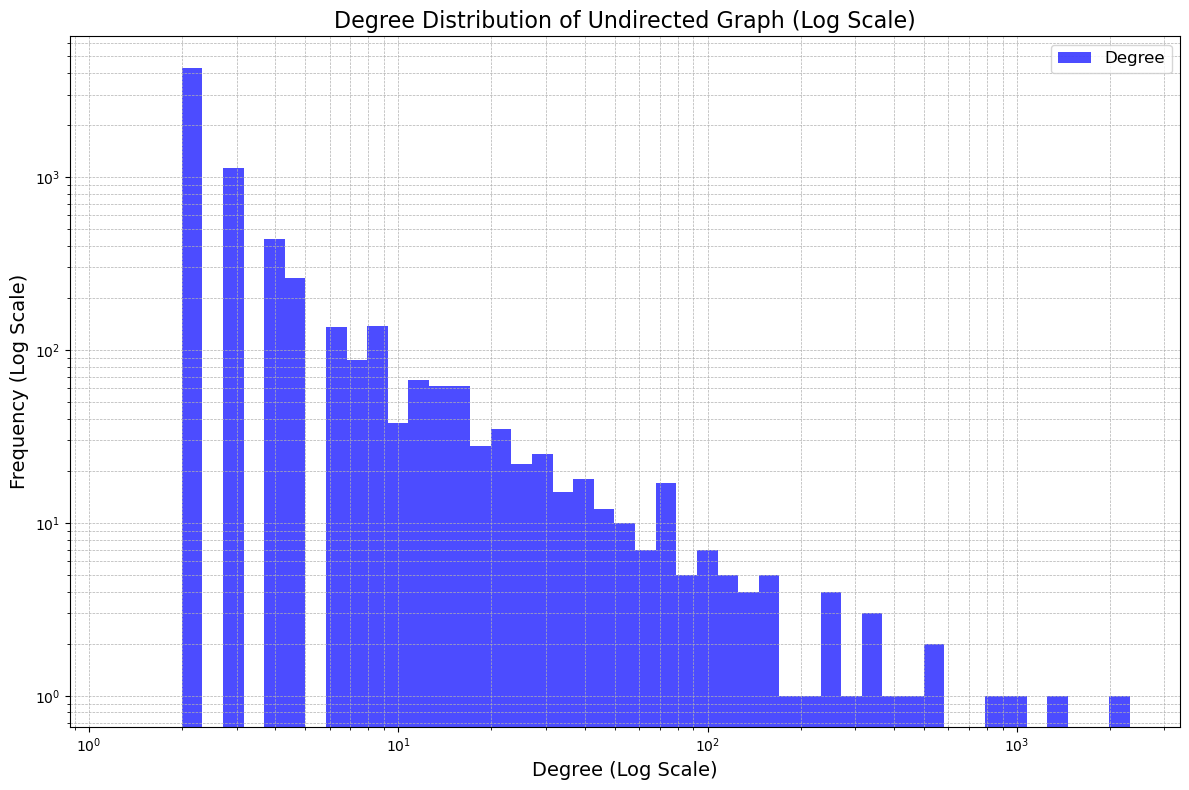

In [67]:

# Calculate degree distribution
degrees = [d for _, d in G.degree()]

# Plot improved degree distribution
plt.figure(figsize=(12, 8))
plt.hist(degrees, bins=np.logspace(0.1, np.log10(max(degrees) + 1), 50), alpha=0.7, color="blue", label="Degree")
plt.xscale("log")  # Use log scale for the x-axis
plt.yscale("log")  # Use log scale for the y-axis if needed
plt.title("Degree Distribution of Undirected Graph (Log Scale)", fontsize=16)
plt.xlabel("Degree (Log Scale)", fontsize=14)
plt.ylabel("Frequency (Log Scale)", fontsize=14)
plt.grid(which="both", linestyle="--", linewidth=0.5)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()


In [ ]:
# Initialize Influence Maximization Class
inf_max = InfluenceMaximization(graph=G, propagation_probability=0.02, monte_carlo=10)

# Step 1: Extract Candidate Nodes Based on IFC Score
nodes_with_ifc_label_1 = [node for node, data in G.nodes(data=True) if data.get("label") == 1]
m = len(nodes_with_ifc_label_1)  # Number of candidate nodes

# Step 2: Select Top-m Nodes for Each Heuristic
def select_top_m_nodes(G, m, heuristic_index):
    """
    Select the top-m nodes based on the given heuristic index.
    """
    nodes_with_features = [(node, G.nodes[node]["features"][heuristic_index]) for node in G.nodes]
    sorted_nodes = sorted(nodes_with_features, key=lambda x: x[1], reverse=True)
    return [node for node, _ in sorted_nodes[:m]]

heuristics = {
    "Degree": 0,
    "Betweenness": 1,
    "K-Core": 2,
    "Average Neighbor Degree": 3,
    "IFC Score": 4
}

candidate_sets = {heuristic: select_top_m_nodes(G, m, index) for heuristic, index in heuristics.items()}

# Initialize Results Dictionary
results = {
    "Number of Nodes": G.number_of_nodes(),
    "Number of Edges": G.number_of_edges(),
    "Greedy Spread": {},
    "Greedy Time": {},
}

for heuristic in heuristics:
    results[f"{heuristic} Spread"] = {}
    results[f"{heuristic} Time"] = {}

k_max = 20  # Maximum seed size
print(f"\nRunning computations for k={k_max}...\n")

# Initialize results storage
results = {"Greedy Spread": [], "Greedy Time": []}
for heuristic in candidate_sets:
    results[f"{heuristic} Spread"] = []
    results[f"{heuristic} Time"] = []

# Greedy Algorithm for k_max
print(f"Running Greedy for k={k_max}...")
greedy_seed_set, greedy_spread, greedy_timelapse = inf_max.greedy(k=k_max)

# Store results for all k values
results["Greedy Spread"] = greedy_spread[:k_max]  # Spread values for all k
results["Greedy Time"] = greedy_timelapse[:k_max]  # Time values for all k

# Heuristic-Based Approaches for k_max
for heuristic, candidate_set in candidate_sets.items():
    print(f"Running {heuristic}-based for k={k_max}...")
    heuristic_seed_set, heuristic_spread, heuristic_timelapse = inf_max.greedy_mod(
        k=k_max, candidatenodelist=candidate_set
    )
    # Store results for all k values
    results[f"{heuristic} Spread"] = heuristic_spread[:k_max]
    results[f"{heuristic} Time"] = heuristic_timelapse[:k_max]




Running computations for k=20...

Running Greedy for k=20...
Running Degree-based for k=20...
Running Betweenness-based for k=20...
Running K-Core-based for k=20...


In [2]:
# Plot Results for All k
import matplotlib.pyplot as plt

k_max = 20

ks = range(1, k_max + 1)

# Spread Plot
plt.figure(figsize=(12, 6))
plt.plot(ks, results["Greedy Spread"], label="Greedy", marker="o")
for heuristic in candidate_sets:
    plt.plot(ks, results[f"{heuristic} Spread"], label=f"{heuristic}-based", marker="x")
plt.xlabel("Seed Set Size (k)")
plt.ylabel("Influence Spread")
plt.title("Influence Spread vs Seed Set Size")
plt.legend()
plt.grid(True)
plt.show()

# Time Plot
plt.figure(figsize=(12, 6))
plt.plot(ks, results["Greedy Time"], label="Greedy", marker="o")
for heuristic in candidate_sets:
    plt.plot(ks, results[f"{heuristic} Time"], label=f"{heuristic}-based", marker="x")
plt.xlabel("Seed Set Size (k)")
plt.ylabel("Computation Time (s)")
plt.title("Computation Time vs Seed Set Size")
plt.legend()
plt.grid(True)
plt.show()

NameError: name 'results' is not defined

<Figure size 1200x600 with 0 Axes>